In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

panel = pd.read_pickle('../Data/returns_chars_panel.pkl') 
macro = pd.read_pickle('../Data/macro_timeseries.pkl')

In [5]:
# combine micro and macro data
df = pd.merge(panel,macro,on='date',how='left',suffixes=['','_macro']) 

# features + targets 
X = df.drop(columns=['ret','excess_ret','rfree','permno','date']) # everything except return info and IDs
y = df['excess_ret'] 

# Split Train Test 

In [19]:
# make 20 years of training data
date = df['date']
training = (date <= '1977-03') # selects 
X_train, y_train = X.loc[training].values, y.loc[training].values 

# make 10 years of validation data
validation = (date > '1977-03') & (date <= '1987-03') 
X_val, y_val = X.loc[validation].values, y.loc[validation].values 

# make test data
test = (date > '1987-03') 
X_test, y_test = X.loc[test].values, y.loc[test].values 

# Finding baseline model for Neural Network 

## 2 layers 

In [57]:
import tensorflow as tf
tf.random.set_seed(999)
from tensorflow.keras.regularizers import L2

def nn1(lamda):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='linear', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal')
    ])
    return model 

def nn2(lamda):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='linear', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal')
    ])
    return model 


def nn3(lamda):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(8, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='linear', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal')
    ])
    return model 

def nn4(lamda):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(8, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='linear', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal')
    ])
    return model 

def nn5(lamda):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(8, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='relu', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='linear', kernel_regularizer = L2(lamda), kernel_initializer = 'he_normal')
    ])
    return model 

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2426 - mse: 0.2417 - val_loss: 0.0347 - val_mse: 0.0338
Epoch 2/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0218 - mse: 0.0209 - val_loss: 0.0291 - val_mse: 0.0282
Epoch 3/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0196 - mse: 0.0187 - val_loss: 0.0281 - val_mse: 0.0272
Epoch 4/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0191 - mse: 0.0182 - val_loss: 0.0278 - val_mse: 0.0270
Epoch 5/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0188 - mse: 0.0181 - val_loss: 0.0279 - val_mse: 0.0271
Epoch 6/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0187 - mse: 0.0180 - val_loss: 0.0277 - val_mse: 0.0271
Epoch 7/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0186 - mse: 0.0179 - val_loss: 0.0277 - val_mse: 0.0272
Epoch 8/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - loss: 0.0184 - mse: 0.0179 - val_loss: 0.0278 - val_mse: 0.0273


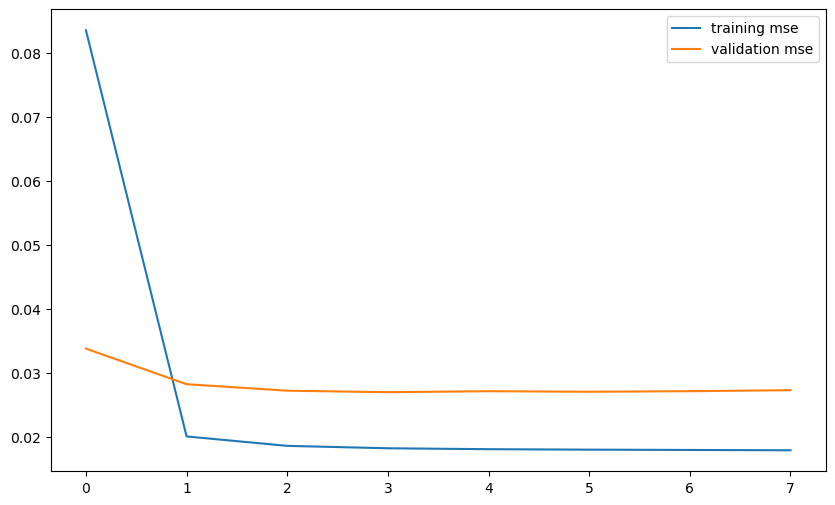

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

# hypers
batch_size = 512
lamda = 1e-5
patience = 2

model = nn2(lamda)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=batch_size, 
                    verbose=True,
                    validation_data = (X_val, y_val),
                    # Defined the callback to see if the validation result actually improves 
                    callbacks = [EarlyStopping(patience = patience, restore_best_weights=True)])

fig, ax = plt.subplots(figsize=(10,6))
pd.Series(history.history['mse']).plot(ax=ax, label='training mse')
pd.Series(history.history['val_mse']).plot(ax=ax, label='validation mse')
ax.legend()

## Cross Validation for Lamda for L2 Regularization 

Best lambda: 1e-05
Validation MSE for the best lambda: 0.016629324480891227
Epoch 1/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3977 - mse: 0.3967 - val_loss: 0.0373 - val_mse: 0.0364
Epoch 2/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0232 - mse: 0.0223 - val_loss: 0.0298 - val_mse: 0.0289
Epoch 3/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0202 - mse: 0.0193 - val_loss: 0.0284 - val_mse: 0.0275
Epoch 4/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0194 - mse: 0.0186 - val_loss: 0.0278 - val_mse: 0.0269
Epoch 5/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0191 - mse: 0.0183 - val_loss: 0.0274 - val_mse: 0.0266
Epoch 6/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0188 - mse: 0.0180 - val_loss: 0.0275 - val_mse: 0.0268
Epoch 7/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0185 - mse: 0.0179 - val_loss: 0.0277 - val_mse: 0.0271


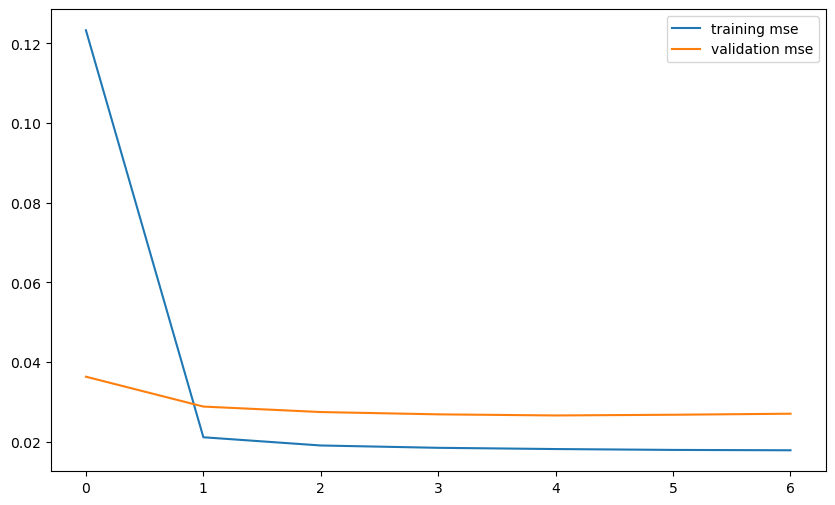

In [63]:
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

epochs = 100

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
best_val_mse = float('inf')
best_lamda = None
history_dict = {}

lamdas = [1e-6, 1e-5, 1e-4, 1e-3]  # Define a list of lambda values to cross-validate

for lamda in lamdas:
    val_mse_folds = []
    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Clear the Keras session to avoid clutter from old models
        K.clear_session()
        
        model = nn2(lamda)
        model.compile(optimizer='adam', loss='mse', metrics=['mse'])
        
        history = model.fit(X_train_fold, y_train_fold, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            verbose=False,
                            validation_data=(X_val_fold, y_val_fold),
                            callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
        
        val_mse_folds.append(min(history.history['val_mse']))
    
    avg_val_mse = np.mean(val_mse_folds)
    history_dict[lamda] = avg_val_mse
    
    if avg_val_mse < best_val_mse:
        best_val_mse = avg_val_mse
        best_lamda = lamda

print(f'Best lambda: {best_lamda}')
print(f'Validation MSE for the best lambda: {best_val_mse}')

# Train the final model with the best lambda
K.clear_session()
model = nn2(best_lamda)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=True,
                    validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])

# Plotting the training and validation MSE
fig, ax = plt.subplots(figsize=(10, 6))
pd.Series(history.history['mse']).plot(ax=ax, label='training mse')
pd.Series(history.history['val_mse']).plot(ax=ax, label='validation mse')
ax.legend()
plt.show()